Data analysis of Severe Accute Respiratoy Sindrome - Sindrome Respiratória Aguda  Grave (in portuguese) provided by Unique System of health (Sistema Único de Saúde - SUS)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from IPython.display import display

We will work with data from SUS (Unified Health System - Brazil) available at https://opendatasus.saude.gov.br/dataset/bd-srag-2020, my version is from February 22th. The files have been updated since I downloaded my copy.
I decided to search for information about Covid's correlation with initial symptoms and pre-existing diseases, in addition to Covid's identification with antigen and PCR test.

In [ ]:
#Leitura dos dados
!wget 'https://s3-sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/2020/INFLUD-22-02-2021.csv'

dados = pd.read_csv('/content/INFLUD-22-02-2021.csv',sep=";", encoding='cp860', 
                    header=0,infer_datetime_format=True,low_memory=False)


--2021-03-03 02:18:11--  https://s3-sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/2020/INFLUD-22-02-2021.csv
Resolving s3-sa-east-1.amazonaws.com (s3-sa-east-1.amazonaws.com)... 52.95.164.70
Connecting to s3-sa-east-1.amazonaws.com (s3-sa-east-1.amazonaws.com)|52.95.164.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 642931906 (613M) [text/csv]
Saving to: ‘INFLUD-22-02-2021.csv’

INFLUD-22-02-2021.c 100%[===================>] 613.15M  10.7MB/s    in 60s     

2021-03-03 02:19:12 (10.3 MB/s) - ‘INFLUD-22-02-2021.csv’ saved [642931906/642931906]



After reading, we need the data dictionary to help us. Below there is the histogram of all notification with Covid cases in red , flu cases in green and undefined in blue.

This dataset contains 1181227 records and 154 attributes.
The data begins on 2019-12-29 00:00:00 and ends on 2021-02-21 00:00:00.
There is 2721 Flu notifications.
There is 409097 undefined notifications.
There is 676670 Covid-19 notifications.


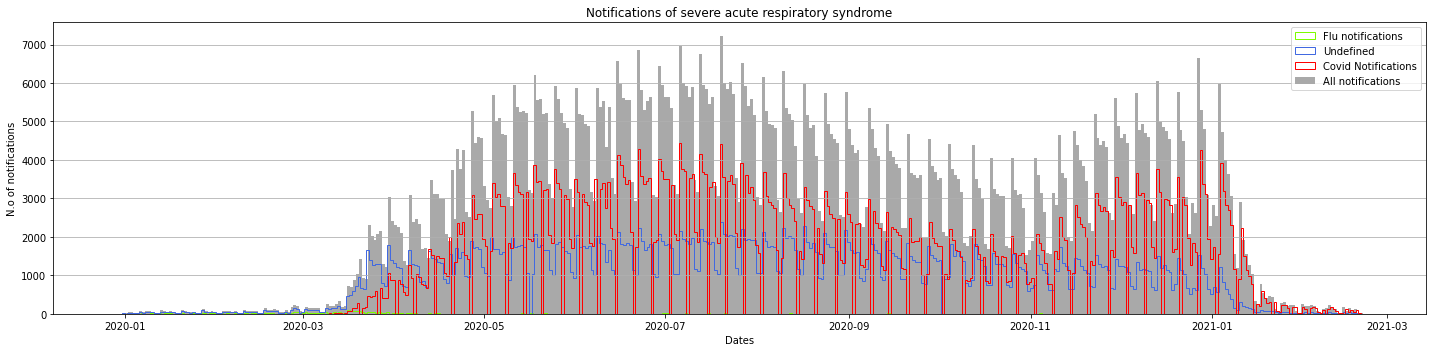

In [ ]:
#Data copy
DadosCopia = dados.copy()

DadosCopia['DT_NOTIFIC'] = pd.to_datetime(DadosCopia['DT_NOTIFIC'],format='%d/%m/%Y')

#Exploratory analizes
size_dados=DadosCopia.shape

min_day=DadosCopia.DT_NOTIFIC.min()
max_day=DadosCopia.DT_NOTIFIC.max()
days = DadosCopia.groupby('DT_NOTIFIC').DT_NOTIFIC.count().index

print('This dataset contains {} records and {} attributes.'.
      format(size_dados[0],size_dados[1]))
print('The data begins on {} and ends on {}.'.
      format(min_day,max_day))
print("There is {} Flu notifications.".format(DadosCopia\
                                              [DadosCopia.CLASSI_FIN==1].\
                                              DT_NOTIFIC.count()))
print("There is {} undefined notifications.".format(DadosCopia\
                                                    [DadosCopia.CLASSI_FIN==4].\
                                                    DT_NOTIFIC.count()))
print("There is {} Covid-19 notifications.".format(DadosCopia\
                                                    [DadosCopia.CLASSI_FIN==5].\
                                                    DT_NOTIFIC.count()))

plt.figure(figsize=((20,5)))

DadosCopia.DT_NOTIFIC.hist(bins=len(days), color='darkgrey')
DadosCopia[DadosCopia.CLASSI_FIN==1].DT_NOTIFIC.hist(bins=len(days), histtype='step',
                                                     color='lawngreen')
DadosCopia[DadosCopia.CLASSI_FIN==4].DT_NOTIFIC.hist(bins=len(days), histtype='step',
                                                     color='royalblue')
DadosCopia[DadosCopia.CLASSI_FIN==5].DT_NOTIFIC.hist(bins=len(days), histtype='step',
                                                     color='red')
plt.legend(['Flu notifications','Undefined',
            'Covid Notifications','All notifications'])
plt.title('Notifications of severe acute respiratory syndrome')
plt.xlabel('Dates')
plt.ylabel('N.o of notifications')
plt.grid(axis='x')
    
plt.tight_layout()
plt.show()


The columns of symptoms and diseases were mapped and associated with some synonym to be searched. This was necessary because there may be information in the description field that was not counted. The search will be carried out in the fields OUTRO_DES and MORB_DESC. 

In [ ]:
#Dictionary of columns and synonyms of symptoms + headache, body pain and coryza
symptoms={'FEBRE':'FEBRE','TOSSE':['PIGARRO','TOSSE'],'DISPNEIA':'DISPNEIA',
            'DESC_RESP':'RESPIRATORIO','SATURACAO':'SATURACAO',
            'DIARREIA':['DIARREIA','CAGANEIRA'],'VOMITO':'VOMITO',
            'DOR_ABD':['ABDOMEN','ABDO','ABDOMINAL','ABD'],
            'FADIGA':['FADIGA','PROSTRACAO'],'PERD_OLFT':['OLFATO','CHEIRO'],
            'PERD_PALA':['GOSTO','PALADAR','AGEUSIA'],
            'DOR_CABECA':['CABECA','CEFALEIA'],'DOR_CORPO':'CORPO',
           'CORIZA':['CORIZA','SECRECAO','CATARRO'],'OUTRO_SIN':'OUTRO_SIN'}

#Creating additional symptoms columns
for sintoma in ['DOR_CORPO','DOR_CABECA','CORIZA']:
    linhas,colunas=DadosCopia.shape
    DadosCopia.insert(colunas,sintoma,np.full(linhas,np.nan))

#Dictionary of columns and synonyms of comorbidities
comorbidity={'PUERPERA':['PUERPERA','PARTURIENTE','PARTO'],
             'CARDIOPATI':['CARDIOPATIA','MIALGIA','PEITO','MIALGIAS'],
             'HEMATOLOGI':'HEMATOLOGI','SIND_DOWN':['DOWN','SIND_DOWN'],
            'HEPATICA':'HEPATICA','ASMA':['ASMA','BRONQUIOLITE'],
             'DIABETES':'DIABETES','NEUROLOGIC':'NEUROLOGIC',
             'PNEUMOPATI':'PNEUMOPATI','IMUNODEPRE':['DEPRESSAO','IMUNODEPRE'],
             'RENAL':['RENAL','RINS','RIM'],'OBESIDADE':'OBESIDADE',
             'OUT_MORBI':['OUTRA','OUT_MORBI']}

def Search_words(search, join, words):
    ''' this function perform a search for Termos in the series ColBusca and \n
    join the results with ColUniao, a series with the original information.\n
    Every time Termos is found in ColBusca, the ColUniao will receive a one.\n
    The result in of the search is mandatory over the register in ColUniao.\n
    Inputs: - ColBusca - series to be searched for \n
              ColUniao - series to be joined with the results of ColBusca\n
              Termos - strings or list of strings to search\n
    Outputs:  Result - ColUniao joined with the results of the search.
    '''

    result = join.copy()   #Cópia da coluna de entrada
    #Check the type of variable
    if type(words) != list:
        words = [words]
    #Substitution of separator between words
    temp=search.replace({',':'', '/':' ', '\+':' ', '-':' ', '=':' ' },
                        regex=True).str.split(expand=True)
    #Terms search
    result_search = temp.isin(words).sum(axis=1)
    #Index
    index = result_search[result_search==1].index.tolist()
    #Inserting 1 where found the word
    result.iloc[index] = 1

    return result

#Searching the symptoms in OUTROS_DES column
for sintoma in symptoms:
    try:
      CasosIn=DadosCopia[DadosCopia[sintoma]==1].shape[0]
      Temp=Search_words(DadosCopia.OUTRO_DES,DadosCopia[sintoma],
                        symptoms[sintoma])
      DadosCopia[sintoma]=Temp
      CasosOut=DadosCopia[DadosCopia[sintoma]==1].shape[0]
      print('The search for synonyms of {0:11s} found {1:5d} occurences and\
       added {2:5.2f}% to the records'.format(sintoma,
                                              CasosOut,
                                              100*(CasosOut-CasosIn)/(1+CasosIn)))
    except:
      continue

#Searching for comorbidities in MORB_DESC
for comorbidade in comorbidity:
    try:
      CasosIn=DadosCopia[DadosCopia[comorbidade]==1].shape[0]
      Temp=Search_words(DadosCopia.MORB_DESC,DadosCopia[comorbidade],
                        comorbidity[comorbidade])
      DadosCopia[comorbidade]=Temp
      CasosOut=DadosCopia[DadosCopia[comorbidade]==1].shape[0]
      print('The search for synonyms of {0:11s} found {1:5d} occurences and\
       added {2:5.2f}% to the records'.format(comorbidade,
                                              CasosOut,
                                              100*(CasosOut-CasosIn)/(1+CasosIn)))
    except:
      continue

#Searching for comorbidities in OUTRO_DES
for comorbidade in comorbidity:
    CasosIn=DadosCopia[DadosCopia[comorbidade]==1].shape[0]
    Temp=Search_words(DadosCopia.OUTRO_DES,DadosCopia[comorbidade],
                      comorbidity[comorbidade])
    DadosCopia[comorbidade]=Temp
    CasosOut=DadosCopia[DadosCopia[comorbidade]==1].shape[0]
    print('The search for synonyms of {0:11s} found {1:5d} occurences and\
     added {2:5.2f}% to the records'.format(comorbidade,
                                            CasosOut,
                                            100*(CasosOut-CasosIn)/(1+CasosIn)))

#Searching for PCR results in DS_PCR_OUT, DS_AN_OUT
Covid_Sinonym=['COVID','COVID-19','CORONAVIRUS','COVID19','SAR','SARS','SRAG']
CampoBusca=['DS_PCR_OUT','DS_AN_OUT']
CampoRes=['AN_SARS2','PCR_SARS2']
for num,campo in enumerate(CampoBusca):
  try:
      CasosIn=DadosCopia[DadosCopia[CampoRes[num]]==1].shape[0]
      Temp=Search_words(DadosCopia[campo],DadosCopia[CampoRes[num]],
                        Covid_Sinonym)
      DadosCopia[CampoRes[num]]=Temp
      CasosOut=DadosCopia[DadosCopia[CampoRes[num]]==1].shape[0]
      print('The search for synonyms of {0:11s} found {1:5d} occurences and \
      added {2:5.2f}% to the records'.format(campo,
                                             CasosOut,
                                             100*(CasosOut-CasosIn)/(1+CasosIn)))
  except:
    continue


The search for synonyms of FEBRE       found 669729 occurences and       added  0.00% to the records
The search for synonyms of TOSSE       found 787632 occurences and       added  0.01% to the records
The search for synonyms of DISPNEIA    found 796806 occurences and       added  0.01% to the records
The search for synonyms of DESC_RESP   found 657766 occurences and       added  0.02% to the records
The search for synonyms of SATURACAO   found 642999 occurences and       added  0.01% to the records
The search for synonyms of DIARREIA    found 146156 occurences and       added  0.51% to the records
The search for synonyms of VOMITO      found 104270 occurences and       added  0.21% to the records
The search for synonyms of DOR_ABD     found 46986 occurences and       added 15.07% to the records
The search for synonyms of FADIGA      found 139740 occurences and       added  5.93% to the records
The search for synonyms of PERD_OLFT   found 58453 occurences and       added  4.90% to the 

Further adjustments to the data set, some attributes have a value of 9 with ignored meaning. It's the same as NaN - not a number - with no value, so let's deal with it. We will remove some redundant attributes and those in AttNum and AttCat will be encoded.

In [ ]:
#The data description use 9 to represent ignored and will be  removed.
#The number 2 means negative, so it will be kept.

DadosCopia.replace(9,np.nan,inplace=True)



Looking for notifications grouped by states. In the first graph, the absolute number of notifications, in the second the proportion between Covid cases per number of notifications and in the third graph, the proportion of Covid deaths in relation to infected patients. 

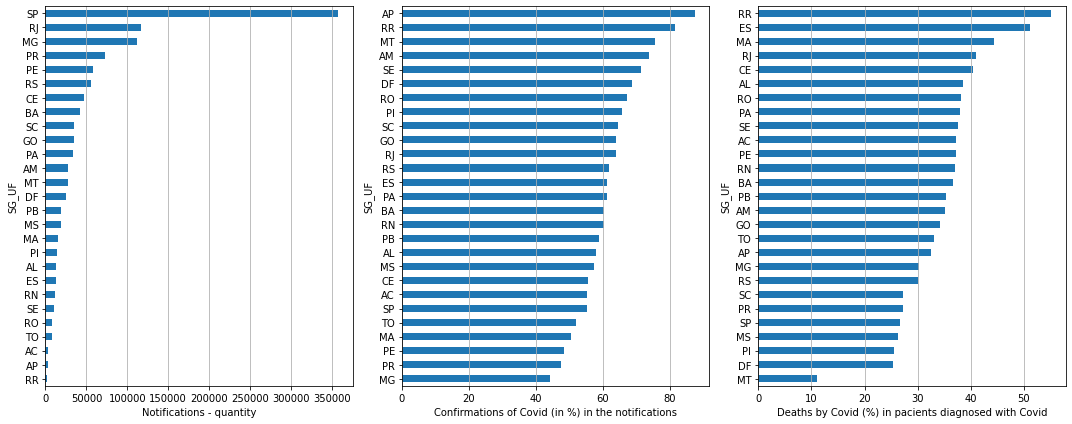

In [ ]:
#States total
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
DadosCopia.groupby('SG_UF').DT_NOTIFIC.count().\
           sort_values(ascending=True).plot.barh()
plt.xlabel('Notifications - quantity')
plt.grid(axis='x')
plt.tight_layout()

#Ranking states by COVID lethality
plt.subplot(1,3,2)
CovidNotification=DadosCopia[(DadosCopia.CLASSI_FIN==5)].groupby('SG_UF').DT_NOTIFIC.count()
Notification=DadosCopia.groupby('SG_UF').DT_NOTIFIC.count()
(100*CovidNotification/Notification).sort_values().plot.barh()
plt.xlabel('Confirmations of Covid (in %) in the notifications')
plt.grid(axis='x')

plt.subplot(1,3,3)
CovidDeath=DadosCopia[(DadosCopia.EVOLUCAO==2) & (DadosCopia.CLASSI_FIN==5) ].\
        groupby('SG_UF').DT_NOTIFIC.count()
(100*CovidDeath/CovidNotification).sort_values().plot.barh()
plt.xlabel('Deaths by Covid (%) in pacients diagnosed with Covid')
plt.grid(axis='x')

plt.tight_layout()
plt.show()

Accordin the dictionary's data the CLASSI_FIN attribute could be:
1 - SARG by Influenza (Flu)
2 - SARG by other virus
3 - SARG by other etimology
4 - SARG not specified
5 - SARG by Covid-19

Whe use just the records with CLASSI_FIN=5 (diagnose of Covid) because CLASSI_FIN=4 (diagnose not specified) are a group with one of those characteristics:
* PCR results negative;
* PCR result inconclusive;
* PCR test not done;
* Waiting result of PCR test. 




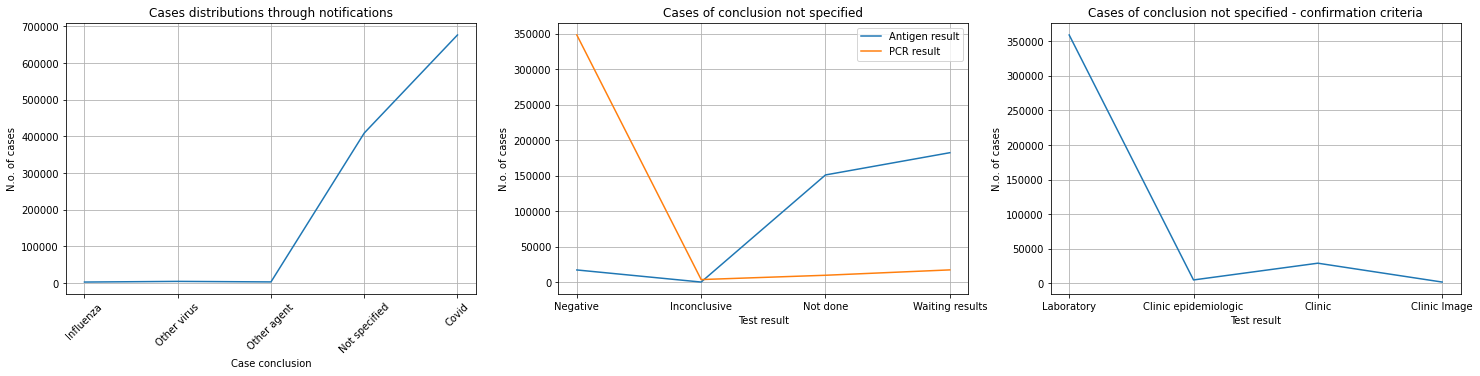

Diagnose not specified: 409097 cases.

Diagnose not specified and PCR result negative: 348060 cases.

Diagnose not specified and PCR result inconclusive: 3598 cases.

Diagnose not specified and PCR not done: 9660 cases.

Diagnose not specified and waiting PCR result: 17220 cases.

Diagnose not specified and antigen result negative: 17133 cases.

Diagnose not specified and antigen result inconclusive: 85 cases.

Diagnose not specified and antigen not done: 150936 cases.

Diagnose not specified and waiting antigen result: 182250 cases.



In [ ]:
plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
plt.plot(DadosCopia.groupby('CLASSI_FIN')['CLASSI_FIN'].count())
plt.xticks([1,2,3,4,5],['Influenza','Other virus',
                        'Other agent','Not specified','Covid'])
plt.grid(axis='both')
plt.xticks(rotation=45)
plt.title('Cases distributions through notifications')
plt.xlabel('Case conclusion')
plt.ylabel('N.o. of cases')
plt.subplot(1,3,2)
plt.plot(DadosCopia[(DadosCopia.CLASSI_FIN==4)].groupby('RES_AN').\
         RES_AN.count())
plt.plot(DadosCopia[(DadosCopia.CLASSI_FIN==4)].groupby('PCR_RESUL').\
         PCR_RESUL.count())
plt.xticks([2,3,4,5],['Negative','Inconclusive','Not done','Waiting results'])
plt.legend(['Antigen result','PCR result'])
plt.title('Cases of conclusion not specified')
plt.xlabel('Test result')
plt.ylabel('N.o. of cases')
plt.grid(axis='both')
plt.subplot(1,3,3)
plt.plot(DadosCopia[(DadosCopia.CLASSI_FIN==4)].\
         groupby('CRITERIO').CRITERIO.count())
plt.xticks([1,2,3,4],['Laboratory','Clinic epidemiologic',
                      'Clinic','Clinic Image'])
plt.title('Cases of conclusion not specified - confirmation criteria')
plt.xlabel('Test result')
plt.ylabel('N.o. of cases')
plt.grid(axis='both')
plt.show()

ToPrint1=int(DadosCopia[(DadosCopia.CLASSI_FIN==4)].groupby('CLASSI_FIN').CLASSI_FIN.count())
ToPrint2,ToPrint3,ToPrint4,ToPrint5=DadosCopia[(DadosCopia.CLASSI_FIN==4)].groupby('PCR_RESUL').CLASSI_FIN.count()
ToPrint6,ToPrint7,ToPrint8,ToPrint9=DadosCopia[(DadosCopia.CLASSI_FIN==4)].groupby('RES_AN').CLASSI_FIN.count()

print('Diagnose not specified: {} cases.\n'.format(ToPrint1))
print('Diagnose not specified and PCR result negative: {} cases.\n'.\
      format(ToPrint2))
print('Diagnose not specified and PCR result inconclusive: {} cases.\n'.\
      format(ToPrint3))
print('Diagnose not specified and PCR not done: {} cases.\n'.format(ToPrint4))
print('Diagnose not specified and waiting PCR result: {} cases.\n'.\
      format(ToPrint5))
print('Diagnose not specified and antigen result negative: {} cases.\n'.\
      format(ToPrint6))
print('Diagnose not specified and antigen result inconclusive: {} cases.\n'.\
      format(ToPrint7))
print('Diagnose not specified and antigen not done: {} cases.\n'.\
      format(ToPrint8))
print('Diagnose not specified and waiting antigen result: {} cases.\n'.\
      format(ToPrint9))


Acording to the Health department the most frequent symptoms of COVID-19 are (https://coronavirus.saude.gov.br/sobre-a-doenca):
* cough (Tosse),
* fever (Febre),
* coryza (Coriza),
* sore throat,
* loss of smell, anosmia (Perd_OLFT),
* change in taste (Perd_PALA),
* gastrointestinal disorders (vomiting (VOMITO), diarrhea (DIARREIA), nausea),
* tiredness, asthenia (FADIGA),
* decreased appetite,
* dyspnoea, shortness of breath (DISPNEIA)

The symptoms in the data add those:
* Head pain (DOR_CABECA),
* Body pain (DOR_CORPO),
* Abdominal pain (DOR_ABD),
* O<sub>2</sub> saturation < 95% (SATURACAO),
* Unconfortable during respiration (DESC_RESP),
* Other symptoms (OUTROS_SIN)

Now, looking in the data for the symptoms:

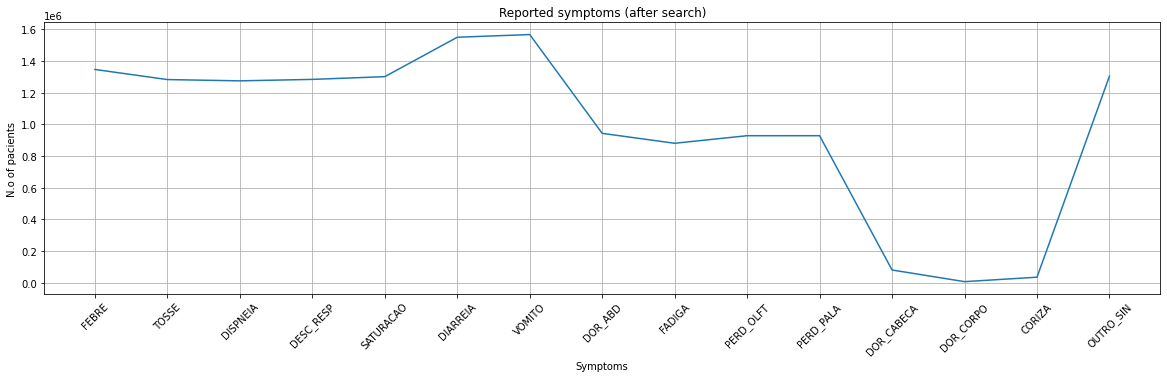

In [ ]:

plt.figure(figsize=(20,5))
plt.plot(DadosCopia[symptoms.keys()].sum())
plt.xticks(rotation=45)
plt.ylabel('N.o of pacients')
plt.xlabel('Symptoms')
plt.title('Reported symptoms (after search)')
plt.grid(axis='both')
plt.show()


Analyzing the correlation between symptoms and pre-existing diseases for the identification of Covid. Is it easy to identify at first sight? 

Number of notifications: 1181227
Number of Covid notifications: 676621


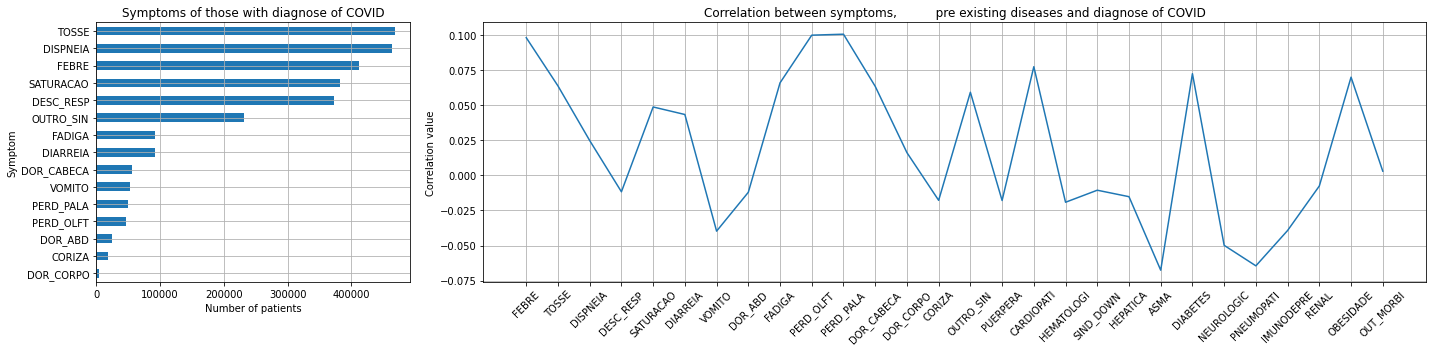

In [ ]:
#Aplying  encoding on some informations only
AttCorr=list(symptoms.keys())+list(comorbidity.keys())+list(['CLASSI_FIN'])
CorrDF=DadosCopia[AttCorr].copy()
CorrDF.loc[:,list(symptoms.keys())+list(comorbidity.keys())].\
           replace(2,np.nan, inplace=True) 
CorrDF=pd.get_dummies(CorrDF,columns=AttCorr)


for num,att in enumerate(AttCorr):
    AttCorr[num]=att+('_1.0')
AttCorr.remove('CLASSI_FIN_1.0')
CorrSeries=CorrDF[AttCorr].corrwith(CorrDF['CLASSI_FIN_5.0']) 
fig=plt.figure(figsize=(20,5))
grid=gridspec.GridSpec(1,2,width_ratios=[1,3])

AttCorr=list(symptoms.keys())
SumSin=DadosCopia[DadosCopia.CLASSI_FIN==5][AttCorr].copy()
SumSin.replace(2,np.nan,inplace=True)
plt.subplot(grid[0])
ax0=SumSin.sum().sort_values().plot.barh()
plt.grid(axis='both')
plt.title('Symptoms of those with diagnose of COVID')
plt.xlabel('Number of patients')
plt.ylabel('Symptom')

plt.subplot(grid[1])
ax1=plt.plot(CorrSeries.values.tolist())
plt.title('Correlation between symptoms, \
         pre existing diseases and diagnose of COVID')
plt.ylabel('Correlation value')
plt.xticks(np.arange(0,CorrSeries.shape[0]),
           labels=list(symptoms.keys())+list(comorbidity.keys()))
plt.xticks(rotation=45)
plt.grid(axis='both')

plt.tight_layout()
print('Number of notifications: {}\nNumber of Covid notifications: {}'.\
      format(DadosCopia.shape[0],CovidNotification.sum()))
del(AttCorr,CorrDF,CorrSeries,SumSin)

According to the chart above, there is a low correlation between analyzed symptoms and Covid. For a better diagnosis, some tests are necessary, such as antigen, PCR and sorology. In the next graph, we see the application of each type of test divided by state.

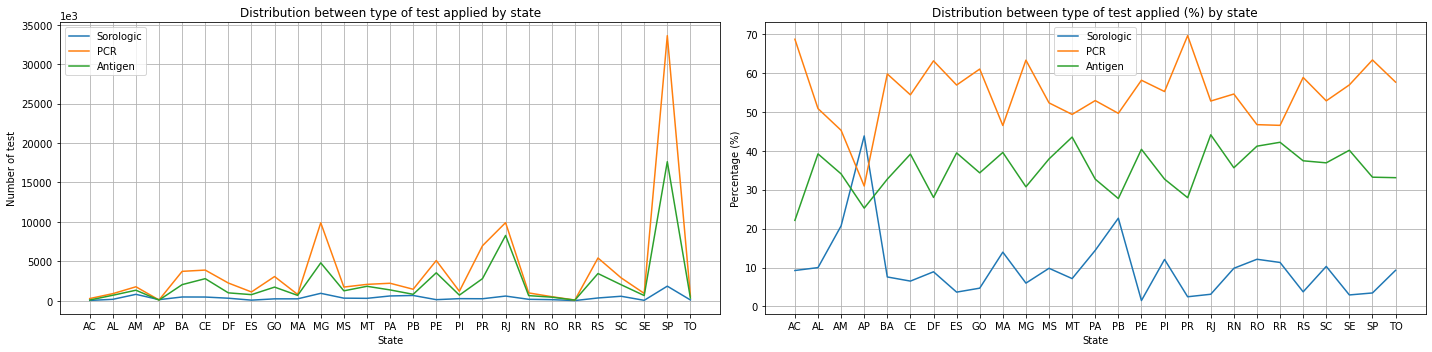

In [ ]:
#Ranking of PCR test, Antigenic e sorologic
TestesSorUF = 100*DadosCopia[~DadosCopia.TP_SOR.isna()].groupby('SG_UF').TP_SOR.count()
TestesPCRUF = 100*DadosCopia[(DadosCopia.PCR_RESUL!=4) & (DadosCopia.PCR_RESUL!=9)].groupby('SG_UF').PCR_RESUL.count()
TestesANUF = 100*DadosCopia[(DadosCopia.RES_AN!=4) & (DadosCopia.RES_AN!=9)].groupby('SG_UF').RES_AN.count()
TesteTotUF = TestesANUF+TestesPCRUF+TestesSorUF
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(TestesSorUF)
plt.plot(TestesPCRUF)
plt.plot(TestesANUF)
plt.ticklabel_format(axis='y',style='sci',scilimits=(3,3))
plt.legend(['Sorologic','PCR','Antigen'])
plt.ylabel('Number of test')
plt.xlabel('State')
plt.title('Distribution between type of test applied by state')
plt.grid()
plt.subplot(1,2,2)
plt.plot(100*TestesSorUF/TesteTotUF)
plt.plot(100*TestesPCRUF/TesteTotUF)
plt.plot(100*TestesANUF/TesteTotUF)
plt.legend(['Sorologic','PCR','Antigen'])
plt.tight_layout()
plt.ylabel('Percentage (%)')
plt.xlabel('State')
plt.title('Distribution between type of test applied (%) by state')
plt.grid()

plt.tight_layout()
plt.show()


We can see the PCR test is more used except in Amapa (AP). Let's dive in to the data to find out why the PCR is the choice to diagnose Covid.

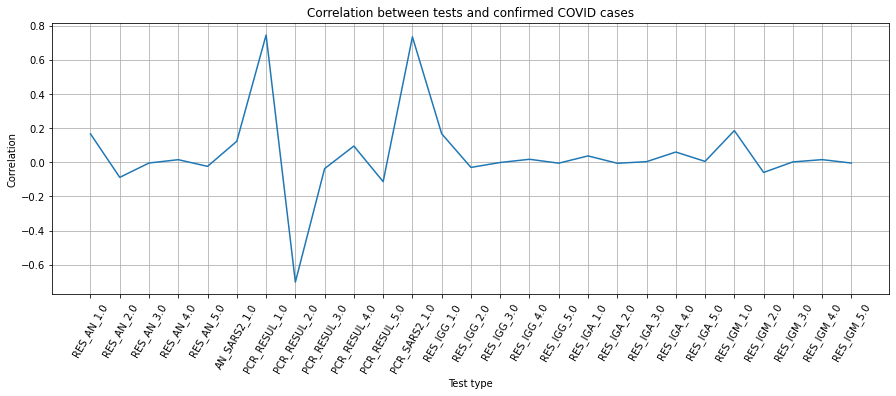

Correlation between tests (antigen and PCR) and diagnose of COVID:


RES_AN_1.0       0.166495
AN_SARS2_1.0     0.123665
PCR_RESUL_1.0    0.745972
PCR_RESUL_2.0   -0.702076
PCR_RESUL_5.0   -0.113191
PCR_SARS2_1.0    0.735359
RES_IGG_1.0      0.167497
RES_IGM_1.0      0.185956
dtype: float64

In [ ]:
#Is there a better COVID identification test?
#Aplying  encoding on some informations only
AttCorr=list(['RES_AN','AN_SARS2','PCR_RESUL','PCR_SARS2',
              'RES_IGG','RES_IGA','RES_IGM','CLASSI_FIN'])
CorrDF=DadosCopia[AttCorr].copy()
CorrDF=pd.get_dummies(CorrDF,columns=AttCorr)
#Removing columns without COVID final calssification
CorrDF.drop(columns=['CLASSI_FIN_1.0','CLASSI_FIN_2.0',
                     'CLASSI_FIN_3.0','CLASSI_FIN_4.0'],
            inplace=True)
AttCorr=CorrDF.columns.tolist()
AttCorr.remove('CLASSI_FIN_5.0')
CorrSeries=CorrDF[AttCorr].corrwith(CorrDF['CLASSI_FIN_5.0'])

plt.figure(figsize=(15,5))
plt.plot(CorrSeries)
plt.xticks(np.arange(0,27),AttCorr,rotation=60)
plt.grid(axis='both')
plt.title('Correlation between tests and confirmed COVID cases')
plt.xlabel('Test type')
plt.ylabel('Correlation')
plt.show()
print('Correlation between tests (antigen and PCR) and diagnose of COVID:')
display(CorrSeries[(CorrSeries>0.1) | (CorrSeries <-0.1)])

del(AttCorr,CorrDF,CorrSeries)


The positive PCR result (PCR_RESUL_1.0) with Covid identification (PCR_SARS2_1.0) has the highest correlation values, which is expected. The surprise is the low correlation with a positive antigen test (RES_AN_1.0) with Covid identification (AN_SARS2_1.0).
We will display the identified virus against the diagnostic to antigen and PCR test.

In [ ]:
#Result of antigenic tests (excluding 4-not done, 5-Waiting e 9-Ignored)
QuantAnt=DadosCopia[(DadosCopia.RES_AN!=4) &(DadosCopia.RES_AN!=5) & \
                    (DadosCopia.RES_AN!=9)][['POS_AN_FLU','AN_SARS2',
                                             'AN_ADENO','CLASSI_FIN']].\
                                             groupby('CLASSI_FIN').count()
#Result of PCR tests (excluding 4-not done, 5-Waiting e 9-Ignored)
QuantPCR=DadosCopia[(DadosCopia.PCR_RESUL!=4) & (DadosCopia.PCR_RESUL!=9) & \
                    (DadosCopia.PCR_RESUL!=5)][['POS_PCRFLU','PCR_SARS2',
                                                'POS_PCROUT','PCR_ADENO',
                                                'PCR_METAP','PCR_BOCA',
                                                'PCR_RINO','PCR_OUTRO',
                                                'CLASSI_FIN']].\
                                                groupby('CLASSI_FIN').count()

display(QuantAnt)
display(QuantPCR)

,POS_AN_FLU,AN_SARS2,AN_ADENO
CLASSI_FIN,,,
1.0,342,14,2
2.0,289,20,25
3.0,8,6,0
4.0,21,9,0
5.0,29107,23752,1


,POS_PCRFLU,PCR_SARS2,POS_PCROUT,PCR_ADENO,PCR_METAP,PCR_BOCA,PCR_RINO,PCR_OUTRO
CLASSI_FIN,,,,,,,,
1.0,1746,2,1056,14,9,0,14,14
2.0,3604,5,4215,395,409,42,2226,169
3.0,14,0,19,1,0,1,3,7
4.0,11,7,12,1,0,0,4,0
5.0,249615,483293,483584,23,12,1,88,3262


Analyzing the result of the antigen test, it is possible to observe the relationship between positive cases for both Influenza (flu) and Covid (SARS 2).

In [ ]:
ResulAnti=DadosCopia[(DadosCopia.RES_AN!=4) &(DadosCopia.RES_AN!=5) & \
                     (DadosCopia.RES_AN!=9) & (DadosCopia.AN_SARS2==1)]\
          [['POS_AN_FLU','AN_SARS2','AN_ADENO','CLASSI_FIN']].\
          groupby('CLASSI_FIN').count()
display(ResulAnti)
print('Ratio between Influenza / Covid = {0:5.2f}%'.\
      format(100*(ResulAnti.POS_AN_FLU/ResulAnti.AN_SARS2)[5.0]))

,POS_AN_FLU,AN_SARS2,AN_ADENO
CLASSI_FIN,,,
1.0,12,14,0
2.0,11,20,0
3.0,4,6,0
4.0,7,9,0
5.0,16089,23752,0


Ratio between Influenza / Covid = 67.74%


Screening the group with a Covid negative antigen test, we found cases of Covid, so the test was unable to detect the SARS 2 virus.

In [ ]:
#False negative
DadosCopia[(DadosCopia.AN_SARS2!=1) & (DadosCopia.RES_AN!=4) & \
           (DadosCopia.RES_AN!=5) & (DadosCopia.RES_AN!=9) & \
           (~DadosCopia.RES_AN.isna())]\
           [['POS_AN_FLU','AN_SARS2','AN_ADENO','CLASSI_FIN']].\
           groupby('CLASSI_FIN').count()

,POS_AN_FLU,AN_SARS2,AN_ADENO
CLASSI_FIN,,,
1.0,328,0,2
2.0,278,0,25
3.0,4,0,0
4.0,0,0,0
5.0,12064,0,1


Repeating the above analyzes for PCR test.

In [ ]:
display(DadosCopia[(DadosCopia.PCR_SARS2==1)][['POS_PCRFLU','PCR_SARS2',
                                               'POS_PCROUT','PCR_ADENO',
                                               'PCR_METAP','PCR_BOCA',
                                               'PCR_RINO','PCR_OUTRO',
                                               'CLASSI_FIN']].\
        groupby('CLASSI_FIN').count())
#false negative
display(DadosCopia[(DadosCopia.PCR_SARS2!=1) & (DadosCopia.PCR_RESUL!=4) & \
                   (DadosCopia.PCR_RESUL!=5) & (~DadosCopia.DT_PCR.isna())]\
        [['POS_PCRFLU','PCR_SARS2','POS_PCROUT','PCR_ADENO','PCR_METAP',
          'PCR_BOCA','PCR_RINO','PCR_OUTRO','CLASSI_FIN']].\
        groupby('CLASSI_FIN').count())


,POS_PCRFLU,PCR_SARS2,POS_PCROUT,PCR_ADENO,PCR_METAP,PCR_BOCA,PCR_RINO,PCR_OUTRO
CLASSI_FIN,,,,,,,,
1.0,1,7,1,0,0,0,0,1
2.0,1,32,1,0,0,0,0,1
3.0,0,2,0,0,0,0,0,0
4.0,0,16,0,0,0,0,0,0
5.0,245398,497023,481535,19,9,1,61,2585


,POS_PCRFLU,PCR_SARS2,POS_PCROUT,PCR_ADENO,PCR_METAP,PCR_BOCA,PCR_RINO,PCR_OUTRO
CLASSI_FIN,,,,,,,,
1.0,1745,0,1055,14,9,0,14,13
2.0,3603,0,4214,395,409,42,2226,168
3.0,14,0,19,1,0,1,3,7
4.0,11,0,12,1,0,0,4,0
5.0,4399,0,2347,4,3,0,27,679


We can identify false negatives for Covid in antigen and PCR tests. We propose to calculate the accuracy and recall to better describe the results.


In [ ]:
#PCR positive to COVID and Covid diagnosis
VerdPosPCR = DadosCopia[(DadosCopia.PCR_SARS2==1)&(DadosCopia.CLASSI_FIN==5)].\
             DT_NOTIFIC.count()
FalsoPosPCR = DadosCopia[(DadosCopia.PCR_SARS2==1)&(DadosCopia.CLASSI_FIN!=5)].\
              DT_NOTIFIC.count()
VerNegPCR=DadosCopia[((DadosCopia.PCR_RESUL==1) | (DadosCopia.PCR_RESUL==2)) &\
                     (DadosCopia.PCR_SARS2.isna()) & \
                     (DadosCopia.CLASSI_FIN!=5)].DT_NOTIFIC.count()
FalsoNegPCR=DadosCopia[((DadosCopia.PCR_RESUL==1) | (DadosCopia.PCR_RESUL==2))&\
                       (DadosCopia.PCR_SARS2.isna()) & \
                       (DadosCopia.CLASSI_FIN==5)].DT_NOTIFIC.count()

#Antigenic
VerdPosAnt=DadosCopia[(DadosCopia.AN_SARS2==1)&(DadosCopia.CLASSI_FIN==5)].\
           DT_NOTIFIC.count()
FalsoPosAnt=DadosCopia[(DadosCopia.AN_SARS2==1)&(DadosCopia.CLASSI_FIN!=5)].\
            DT_NOTIFIC.count()
VerdNegAnt=DadosCopia[((DadosCopia.RES_AN==1)|(DadosCopia.RES_AN==2))&\
                      (DadosCopia.AN_SARS2.isna())&(DadosCopia.CLASSI_FIN==5)].\
                      DT_NOTIFIC.count()
FalsoNegAnt=DadosCopia[((DadosCopia.RES_AN==1)|(DadosCopia.RES_AN==2))&\
                       (DadosCopia.AN_SARS2.isna())&\
                       (DadosCopia.CLASSI_FIN!=5)].DT_NOTIFIC.count()

#Calculation of Precision and Recall - PCR
Precision_PCR=VerdPosPCR/(VerdPosPCR+FalsoPosPCR)
Recall_PCR=VerdPosPCR/(VerdPosPCR+FalsoNegPCR)

#Calculation of Precision and Recall - Antigenic
Precision_Ant=VerdPosAnt/(VerdPosAnt+FalsoPosAnt)
Recall_Ant=VerdPosAnt/(VerdPosAnt+FalsoNegAnt)

#Comparing Precision and Recall to PCR and Antigenic
print('Precision {0:5.2f} and Recall {1:5.2f} - PCR test'.\
      format(Precision_PCR,Recall_PCR))
print('Precision {0:5.2f} and Recall {1:5.2f} - Antigen test'.\
      format(Precision_Ant,Recall_Ant))

Precision  1.00 and Recall  0.88 - PCR test
Precision  0.99 and Recall  0.56 - Antigen test


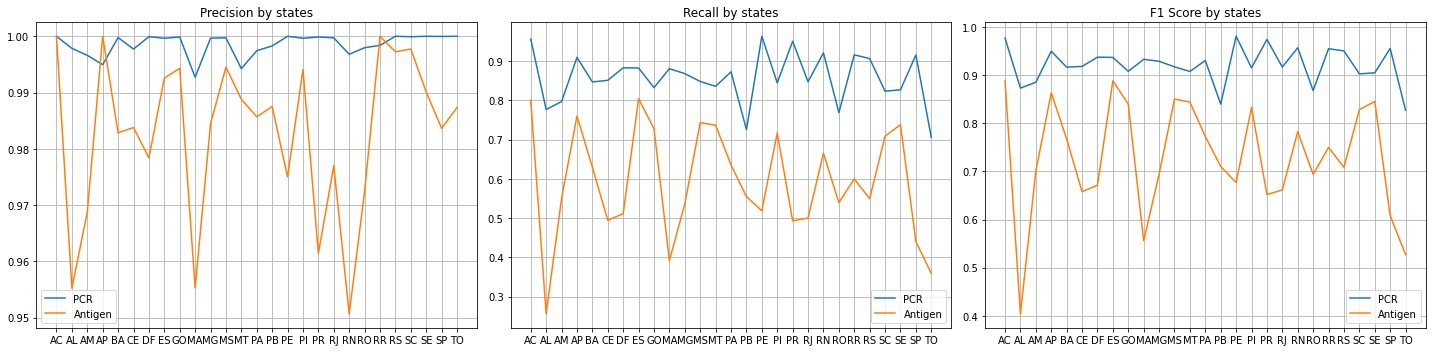

In [ ]:
#PCR positive to Covid e diagnose of Covid
VerdPosPCR = DadosCopia[(DadosCopia.PCR_SARS2==1)&(DadosCopia.CLASSI_FIN==5)].\
             groupby('SG_UF').DT_NOTIFIC.count()
FalsoPosPCR = pd.Series(np.zeros((DadosCopia.SG_UF.unique().shape)))
FalsoPosPCR = DadosCopia[(DadosCopia.PCR_SARS2==1)&(DadosCopia.CLASSI_FIN!=5)].\
              groupby('SG_UF').DT_NOTIFIC.count()
VerNegPCR=DadosCopia[((DadosCopia.PCR_RESUL==1) | (DadosCopia.PCR_RESUL==2)) &\
                     (DadosCopia.PCR_SARS2.isna()) & \
                     (DadosCopia.CLASSI_FIN!=5)].groupby('SG_UF').\
                     DT_NOTIFIC.count()
FalsoNegPCR=DadosCopia[((DadosCopia.PCR_RESUL==1) | (DadosCopia.PCR_RESUL==2))&\
                       (DadosCopia.PCR_SARS2.isna()) & \
                       (DadosCopia.CLASSI_FIN==5)].\
                       groupby('SG_UF').DT_NOTIFIC.count()

#Antigenic
VerdPosAnt=DadosCopia[(DadosCopia.AN_SARS2==1)&(DadosCopia.CLASSI_FIN==5)].\
           groupby('SG_UF').DT_NOTIFIC.count()
FalsoPosAnt=DadosCopia[(DadosCopia.AN_SARS2==1)&(DadosCopia.CLASSI_FIN!=5)].\
            groupby('SG_UF').DT_NOTIFIC.count()
VerdNegAnt=DadosCopia[((DadosCopia.RES_AN==1)|(DadosCopia.RES_AN==2))&\
                      (DadosCopia.AN_SARS2.isna())&(DadosCopia.CLASSI_FIN==5)].\
                      groupby('SG_UF').DT_NOTIFIC.count()
FalsoNegAnt=DadosCopia[((DadosCopia.RES_AN==1)|(DadosCopia.RES_AN==2))&\
                       (DadosCopia.AN_SARS2.isna())&\
                       (DadosCopia.CLASSI_FIN!=5)].\
                       groupby('SG_UF').DT_NOTIFIC.count()

#Series to combine and obtain results by state
Combine=pd.Series(np.zeros(27),index=DadosCopia[~DadosCopia.SG_UF.isna()].\
                  SG_UF.unique())

#Calculation of Precision and Recall - PCR - by state
Precision_PCR=VerdPosPCR/(VerdPosPCR+FalsoPosPCR.\
                          combine(Combine,max,fill_value=0))
Recall_PCR=VerdPosPCR/(VerdPosPCR+FalsoNegPCR.\
                       combine(Combine,max,fill_value=0))

#Calculation of Precision and Recall - Antígeno - by state
Precision_Ant=VerdPosAnt/(VerdPosAnt+FalsoPosAnt.\
                          combine(Combine,max,fill_value=0))
Recall_Ant=VerdPosAnt/(VerdPosAnt+FalsoNegAnt.\
                       combine(Combine,max,fill_value=0))

states=DadosCopia.SG_UF.dropna().unique().tolist()

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(Precision_PCR[~Precision_PCR.isna()])
plt.plot(Precision_Ant[~Precision_Ant.isna()])
plt.legend(['PCR','Antigen'])
plt.grid(axis='both')
plt.title('Precision by states')
plt.subplot(1,3,2)
plt.plot(Recall_PCR[~Recall_PCR.isna()])
plt.plot(Recall_Ant[~Recall_Ant.isna()])
plt.legend(['PCR','Antigen'])
plt.grid(axis='both')
plt.title('Recall by states')
plt.subplot(1,3,3)
plt.plot(2*Precision_PCR*Recall_PCR/(Precision_PCR+Recall_PCR))
plt.plot(2*Precision_Ant*Recall_Ant/(Precision_Ant+Recall_Ant).\
         combine(Combine,max,fill_value=0))
plt.legend(['PCR','Antigen'])
plt.grid(axis='both')
plt.title('F1 Score by states')

plt.tight_layout()
plt.show()

In [ ]:
#Check AC e RR results of Antigenic and PCR Covid Positive
DadosCopia[(DadosCopia.SG_UF=='AC' ) | (DadosCopia.SG_UF=='RR')]\
          [['SG_UF','AN_SARS2','PCR_SARS2']].groupby('SG_UF').count()

,AN_SARS2,PCR_SARS2
SG_UF,,
AC,16,1375
RR,9,613
